In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

print(f'Running on PyMC3 v.{pm.__version__} with ArviZ v.{az.__version__}')

Running on PyMC3 v.3.11.2 with ArviZ v.0.11.2


## Sample from $\mathcal N(0,1)$ with PyMC3

In [20]:
simple_model = pm.Model()

with simple_model:
    x = pm.Normal('x', 0, 1)

with simple_model:
    #step = pm.Metropolis()#scaling=100)#0.1)
    step = pm.HamiltonianMC()#adapt_step_size=False, scaling=np.array([100]))
    inf_data = pm.sample(draws=1000, step=step, 
                          start=[{'x': -2.0}, 
                                 {'x': 2.0}], 
                          chains=2, tune=100,
                          discard_tuned_samples=False, 
                          random_seed=22, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [x]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 1 seconds.


In [3]:
inf_data

Inference data with groups:
	> posterior
	> sample_stats

Warmup iterations saved (warmup_*).

In [4]:
type(inf_data)

arviz.data.inference_data.InferenceData

In [5]:
print(inf_data.posterior['x'].values.shape)
inf_data.posterior['x'].values

(2, 1000)


array([[-1.07828796, -0.39273752,  0.09970783, ..., -0.75781964,
        -0.75781964, -0.87544238],
       [ 0.35047523,  0.35047523, -0.99424166, ...,  0.83450058,
         0.83450058,  0.33211973]])

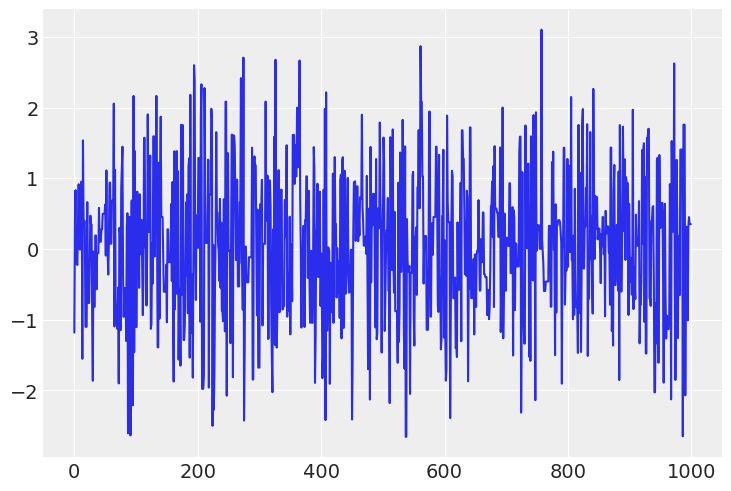

In [21]:
x_values_ch0 = inf_data.posterior['x'].values[0,:]
plt.plot(x_values_ch0)
plt.show()

In [7]:
az.style.use('arviz-darkgrid')
#az.style.use('default')
#az.style.use('arviz-whitegrid')

In [8]:
import os
print(os.listdir(os.path.join(os.path.dirname(az.__file__), 'plots', 'styles')))

['arviz-plasmish.mplstyle', 'arviz-grayscale.mplstyle', 'arviz-bluish.mplstyle', 'arviz-orangish.mplstyle', 'arviz-redish.mplstyle', 'arviz-purplish.mplstyle', 'arviz-greenish.mplstyle', 'arviz-whitegrid.mplstyle', 'arviz-darkgrid.mplstyle', 'arviz-brownish.mplstyle', 'arviz-viridish.mplstyle', 'arviz-cyanish.mplstyle', 'arviz-royish.mplstyle', 'arviz-colors.mplstyle', 'arviz-white.mplstyle']


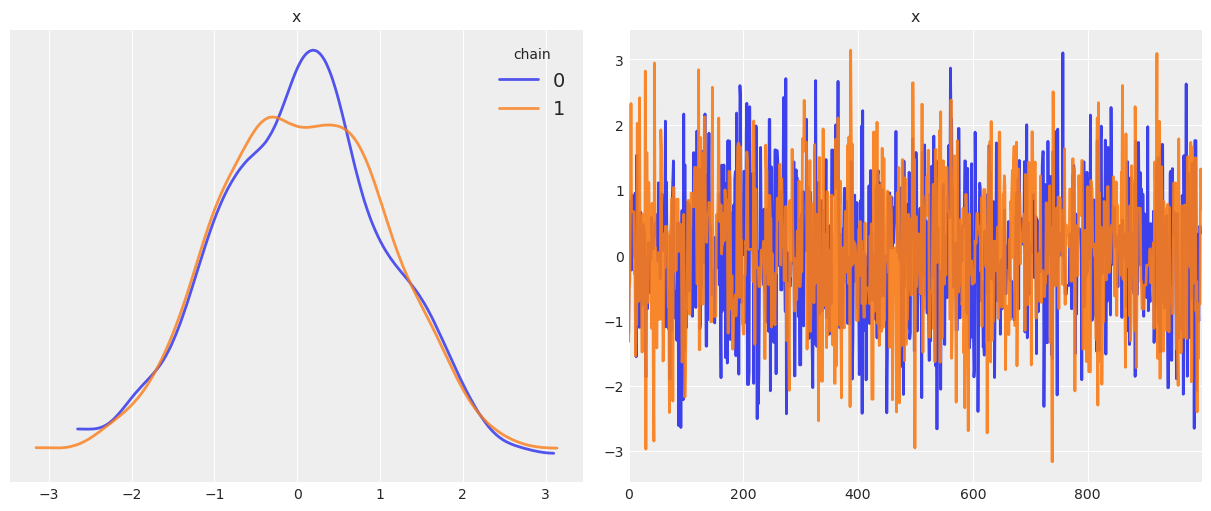

In [22]:
az.plot_trace(inf_data, legend=True, figsize=(12,5),
              trace_kwargs={'linewidth' : 2,
                           'alpha' : 0.9},
              plot_kwargs={'linewidth' : 2,
                           'alpha' : 0.8},
              compact=False
             )
plt.show()

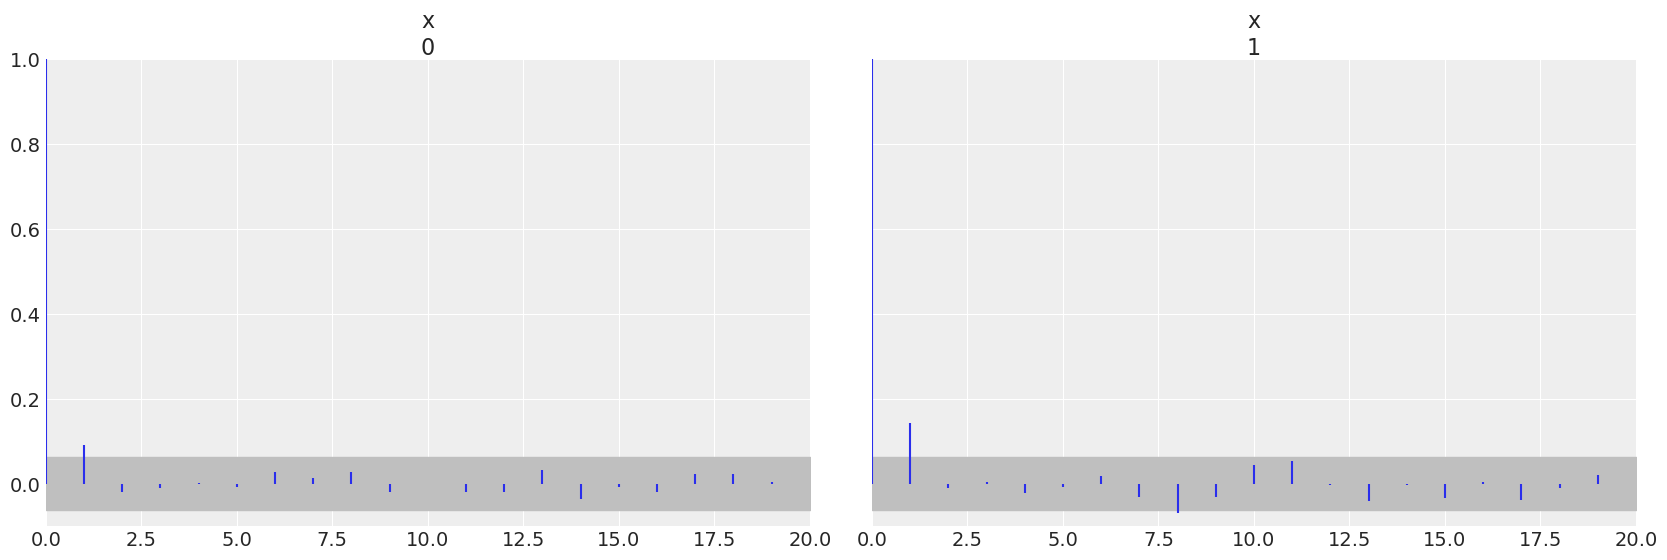

In [23]:
az.plot_autocorr(inf_data, max_lag=20)
plt.ylim([-0.1, 1])
plt.show()

In [24]:
az.rhat(inf_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.0

In [25]:
az.ess(inf_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.637e+03

In [26]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.044,1.037,-1.936,1.921,0.026,0.023,1637.0,1299.0,1.0


# Bimodal Distribution

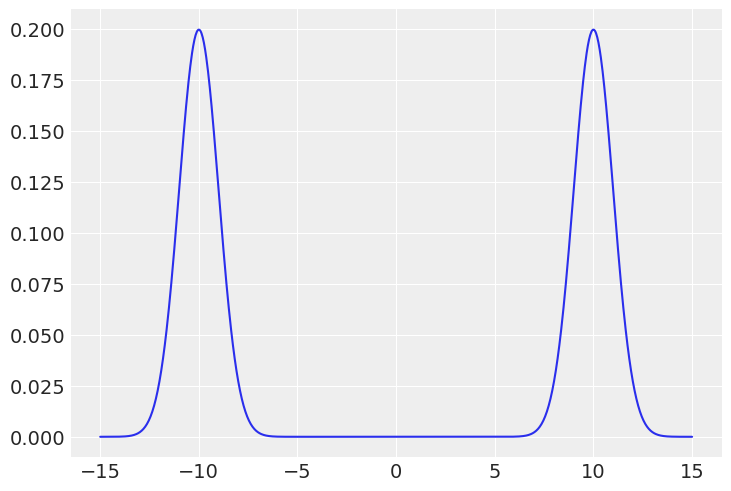

In [27]:
from scipy.stats import norm

w = np.array([0.5, 0.5])
mu = np.array([-10, 10])
sigma = np.array([1, 1])

mix_norm_pdf = lambda z: w.dot(norm.pdf(z, loc=mu, scale=sigma))
x_grid = np.linspace(-15, 15, 1000)
plt.plot(x_grid, [mix_norm_pdf(z) for z in x_grid])
plt.show()

In [34]:
mix_model = pm.Model()

with mix_model:
    x = pm.distributions.mixture.NormalMixture('x', w=w, mu=mu, sigma=sigma)
    
with mix_model:
    #step = pm.Metropolis()#(scaling=100)#0.1)
    step = pm.HamiltonianMC()#adapt_step_size=False, scaling=np.array([100]))
    inf_data = pm.sample(draws=1000, step=step, 
                      start=[{'x': -12.0}, 
                             {'x': 12.0}], 
                      chains=2, tune=0,
                      #discard_tuned_samples=False, 
                      random_seed=22, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [x]


Sampling 2 chains for 0 tune and 1_000 draw iterations (0 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9950055094389073, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9951035470714775, but should be close to 0.65. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


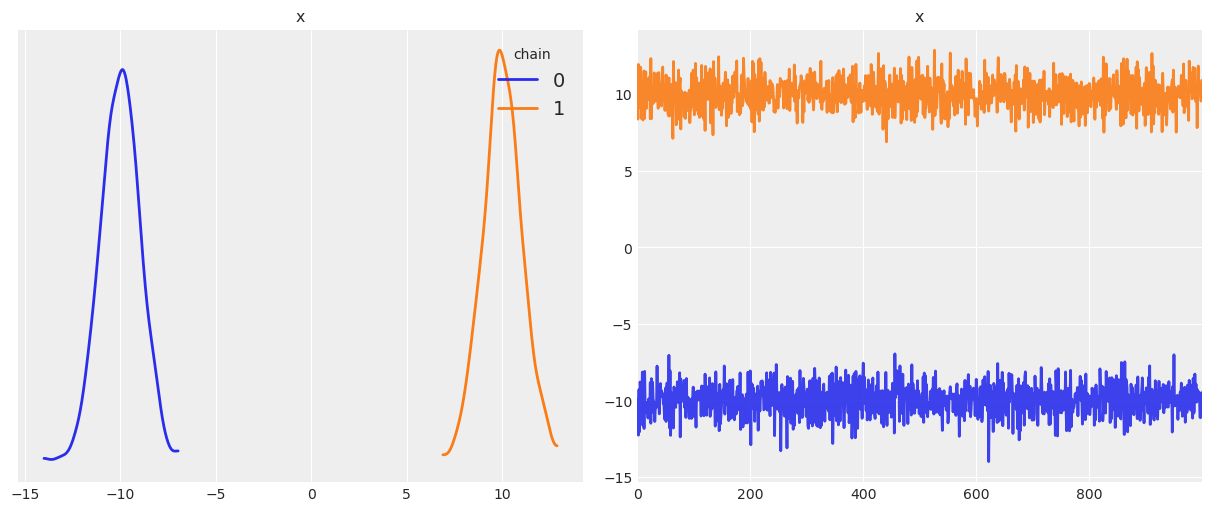

In [35]:
az.plot_trace(inf_data, legend=True, figsize=(12,5),
              trace_kwargs={'linewidth' : 2,
                           'alpha' : 0.9},
              plot_kwargs={'linewidth' : 2,
                           'alpha' : 1},
              compact=False
             )
plt.show()

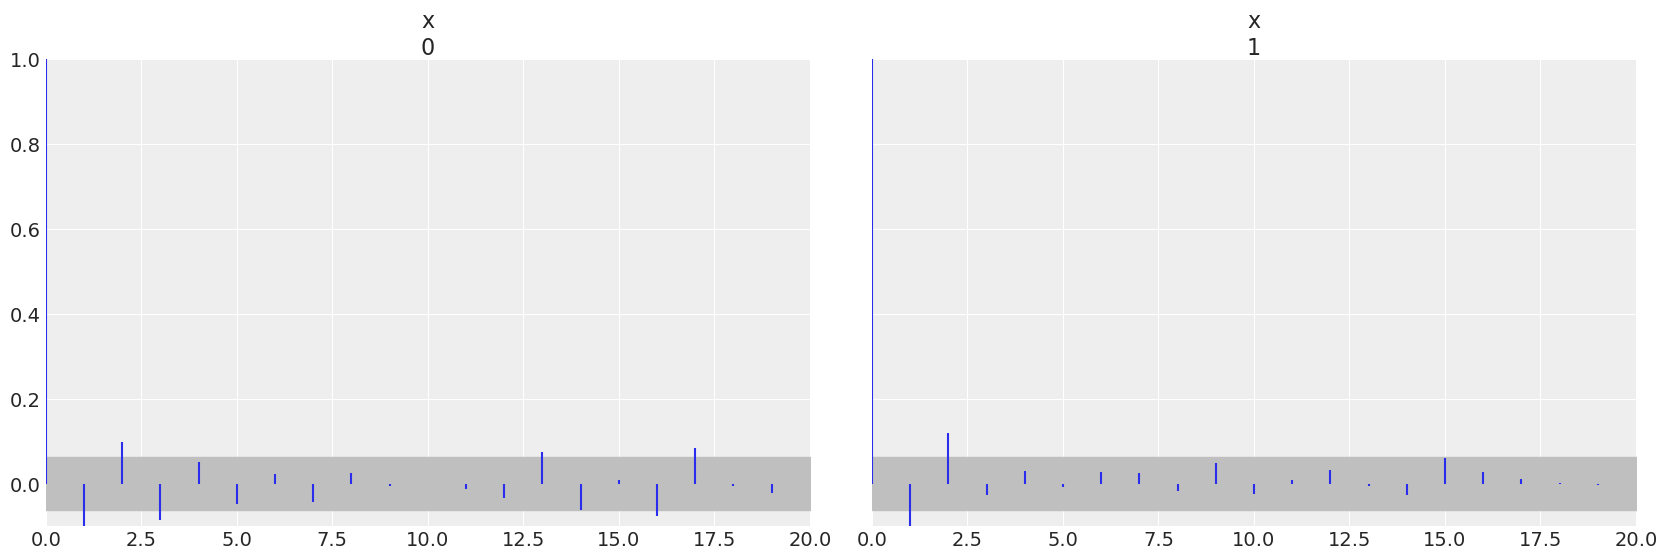

In [36]:
az.plot_autocorr(inf_data, max_lag=20)
plt.ylim([-0.1, 1])
plt.show()

In [33]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.122,10.214,-11.125,12.197,7.168,6.054,3.0,35.0,1.93


# 2d Gaussian

In [37]:
from scipy.stats import multivariate_normal, norm

gt_mu = np.array([0, 0])
gt_Sigma = np.array([[1, -0.99],
                     [-0.99, 1]])
target_distr = multivariate_normal(mean=gt_mu, cov=gt_Sigma)

In [49]:
twodim_model = pm.Model()

with twodim_model:
    x = pm.MvNormal('x', mu=gt_mu, cov=gt_Sigma,
                   shape=(2,))
    
    #step = pm.Metropolis()#scaling=0.1)
    step = pm.HamiltonianMC()#adapt_step_size=False, scaling=np.array([100]))
    inf_data = pm.sample(draws=1000, step=step,
                          chains=2, tune=1000,
                          start=[{'x': [-2,-2]},
                                 {'x': [+2,+2]}],
                          #discard_tuned_samples=False, 
                          random_seed=22, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [39]:
inf_data.posterior['x'].values.shape

(2, 100, 2)

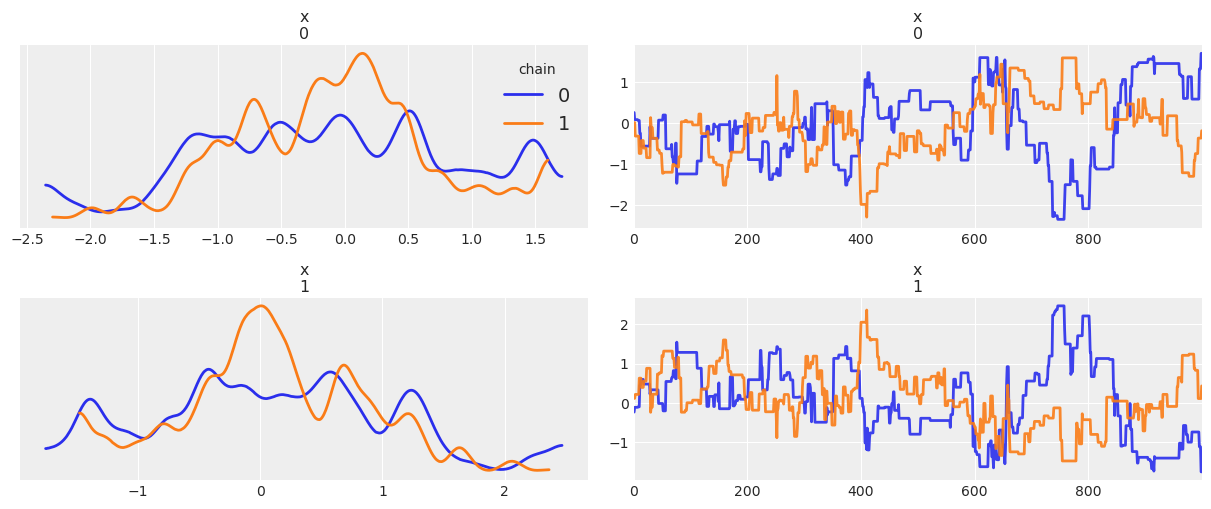

In [50]:
az.plot_trace(inf_data, legend=True, figsize=(12,5),
             trace_kwargs={'linewidth' : 2,
                          'alpha' : 0.9},
             plot_kwargs={'linewidth' : 2,
                          'alpha' : 1},
              compact=False
             )
plt.show()

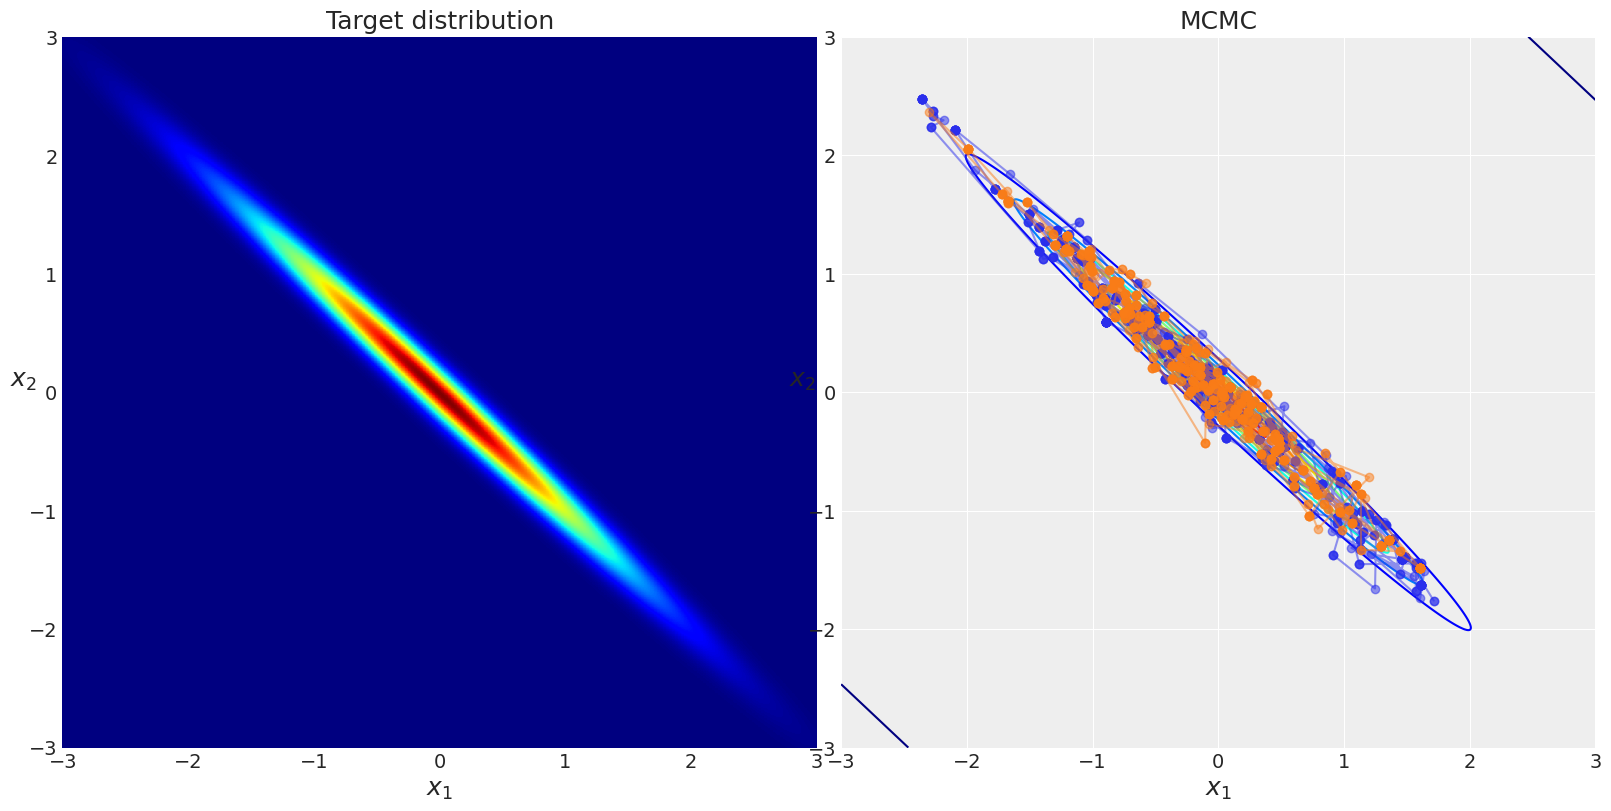

In [51]:
n_grid = 1000
x1 = np.linspace(-3, 3, n_grid)
x1_mg, x2_mg = np.meshgrid(x1, x1)
x_mg = np.stack((x1_mg, x2_mg), axis=-1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Target distribution', fontsize=18)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, rotation=0)
plt.pcolormesh(x1_mg, x2_mg, target_distr.pdf(x_mg), cmap='jet', shading='auto')

plt.subplot(1, 2, 2)
plt.title('MCMC', fontsize=18)
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, rotation=0)
plt.xlim(-3,3)
plt.ylim(-3,3)
x1_chain0 = inf_data.posterior['x'].values[0,:,0]
x2_chain0 = inf_data.posterior['x'].values[0,:,1]
plt.plot(x1_chain0, x2_chain0, marker='o', alpha=.5)
x1_chain1 = inf_data.posterior['x'].values[1,:,0]
x2_chain1 = inf_data.posterior['x'].values[1,:,1]
plt.plot(x1_chain1, x2_chain1, marker='o', alpha=.5)
plt.contour(x1_mg, x2_mg, target_distr.pdf(x_mg), cmap='jet')
plt.show()

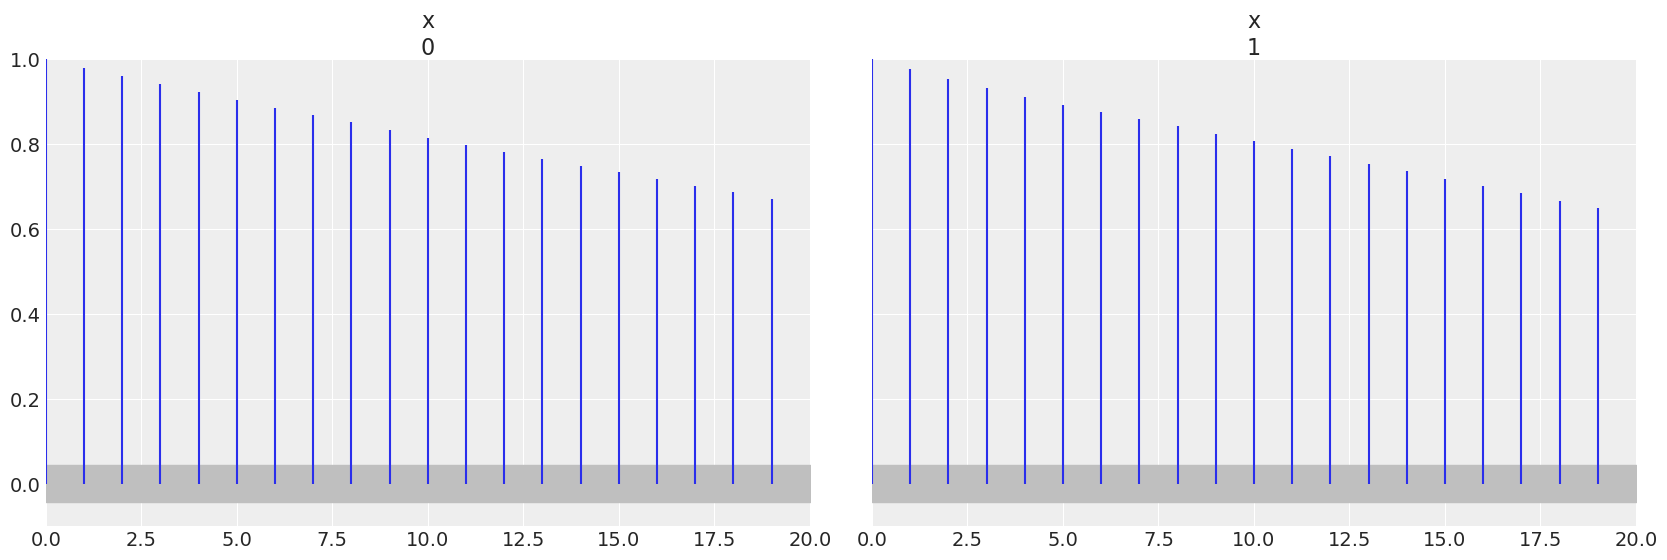

In [52]:
az.plot_autocorr(inf_data, max_lag=20, combined=True)
plt.ylim([-0.1, 1])
plt.show()

In [53]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],-0.101,0.86,-1.317,1.638,0.181,0.129,23.0,42.0,1.11
x[1],0.102,0.85,-1.487,1.432,0.175,0.125,24.0,33.0,1.11
